# Weather

## create plots

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

# --- Configuration ---
WEATHER_FILE = "pliezhausen_weather_2.csv"
NDVI_FILE = "ndvi_light_growth_f_b.csv"
OUTPUT_DIR = "daily_analysis_plots_by_camera"

try:
    # --- Create Output Directory ---
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
        print(f"Created output directory: '{OUTPUT_DIR}'")

    # --- Data Loading ---
    # 1. Load the weather data
    print("Reading weather data...")
    df_weather = pd.read_csv(
        WEATHER_FILE,
        header=None,
        skiprows=1,
        usecols=[0, 2],
        on_bad_lines='skip'
    )
    df_weather.columns = ['timestamp', 'cloudiness']
    df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])
    df_weather.sort_values('timestamp', inplace=True)
    df_weather.dropna(inplace=True)
    dates_from_weather_file = df_weather['timestamp'].dt.date.unique()

    # 2. Load the NDVI and brightness data
    print("Reading NDVI and brightness data...")
    df_ndvi = pd.read_csv(NDVI_FILE)
    df_ndvi.rename(columns={'datetime': 'timestamp', 'mean': 'ndvi'}, inplace=True)
    # UPDATED: Keep the 'camera' column
    df_ndvi = df_ndvi[['timestamp', 'brightness', 'ndvi', 'camera']]
    df_ndvi['timestamp'] = pd.to_datetime(df_ndvi['timestamp'])
    df_ndvi.sort_values('timestamp', inplace=True)

    # --- Data Merging ---
    print("Merging datasets based on nearest timestamp...")
    df_merged = pd.merge_asof(
        left=df_ndvi,
        right=df_weather,
        on='timestamp',
        direction='nearest',
        tolerance=pd.Timedelta('10min')
    )
    df_merged.dropna(inplace=True)
    df_merged['date'] = df_merged['timestamp'].dt.date
    df_final = df_merged[df_merged['date'].isin(dates_from_weather_file)]

    if df_final.empty:
        print("No matching data found.")
    else:
        print(f"Found data for {len(df_final['date'].unique())} days to plot.")

    # --- Plotting Loop ---
    for day in sorted(df_final['date'].unique()):
        day_str = day.strftime('%Y-%m-%d')
        df_day = df_final[df_final['date'] == day]

        # NEW: Get unique cameras for the current day
        unique_cameras_on_day = df_day['camera'].unique()

        # NEW: Loop through each camera found on this day
        for camera_name in unique_cameras_on_day:
            df_day_camera = df_day[df_day['camera'] == camera_name]

            if len(df_day_camera) < 2:
                print(f"  Skipping {day_str} for {camera_name}, not enough data points.")
                continue

            print(f"  Generating plot for {day_str} on {camera_name}...")

            fig, ax1 = plt.subplots(figsize=(18, 9))

            # AXIS 1: Brightness 
            color = 'gold'
            ax1.set_xlabel('Time of Day', fontsize=12)
            ax1.set_ylabel('Brightness', color=color, fontsize=12)
            line1 = ax1.plot(df_day_camera['timestamp'], df_day_camera['brightness'], color=color, marker='o', linestyle='-', label='Brightness')
            ax1.tick_params(axis='y', labelcolor=color)
            ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

            # AXIS 2: NDVI (right) - This was commented out in your script
            ax2 = ax1.twinx()
            color = 'green'
            ax2.set_ylabel('NDVI', color=color, fontsize=12)
            line2 = ax2.plot(df_day_camera['timestamp'], df_day_camera['ndvi'], color=color, marker='o', linestyle='-', label='NDVI')
            ax2.tick_params(axis='y', labelcolor=color)

            # AXIS 3: Cloudiness
            ax3 = ax1.twinx()
            ax3.spines['right'].set_position(('outward', 60))
            color = 'skyblue'
            ax3.set_ylabel('Cloudiness (Humidity %)', color=color, fontsize=12)
            line3 = ax3.plot(df_day_camera['timestamp'], df_day_camera['cloudiness'], color=color, marker='o', linestyle='-', label='Cloudiness')
            ax3.tick_params(axis='y', labelcolor=color)

            ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
            fig.autofmt_xdate()
            plt.title(f'NDVI, Brightness, and Cloudiness for {camera_name} on {day_str}', fontsize=16)
            all_lines = line1 + line2 #+ line3
            all_labels = [l.get_label() for l in all_lines]
            ax1.legend(all_lines, all_labels, loc='upper left')

            fig.tight_layout()

            # Save the plot
            # UPDATED: Filename now includes camera name
            output_path = os.path.join(OUTPUT_DIR, f"ndvi_brightness{day_str}_{camera_name}.png")
            plt.savefig(output_path)
            plt.close(fig)

            print(f"    Saved plot as '{output_path}'")

except FileNotFoundError as e:
    print(f"❌ Error: The file '{e.filename}' was not found.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Reading weather data...
Reading NDVI and brightness data...
Merging datasets based on nearest timestamp...
Found data for 11 days to plot.
  Generating plot for 2025-09-04 on ba_1...
    Saved plot as 'daily_analysis_plots_by_camera/ndvi_brightness2025-09-04_ba_1.png'
  Generating plot for 2025-09-04 on ba_2...
    Saved plot as 'daily_analysis_plots_by_camera/ndvi_brightness2025-09-04_ba_2.png'
  Generating plot for 2025-09-05 on ba_4...
    Saved plot as 'daily_analysis_plots_by_camera/ndvi_brightness2025-09-05_ba_4.png'
  Generating plot for 2025-09-05 on ba_3...
    Saved plot as 'daily_analysis_plots_by_camera/ndvi_brightness2025-09-05_ba_3.png'
  Generating plot for 2025-09-06 on ba_3...
    Saved plot as 'daily_analysis_plots_by_camera/ndvi_brightness2025-09-06_ba_3.png'
  Generating plot for 2025-09-06 on ba_4...
    Saved plot as 'daily_analysis_plots_by_camera/ndvi_brightness2025-09-06_ba_4.png'
  Generating plot for 2025-09-07 on ba_3...
    Saved plot as 'daily_analysis_plo

## Relationships

### a) Brightness affects NDVI
### b) Cloudiness affects Brightness

In [2]:
import pandas as pd
import os
from scipy.stats import pearsonr

WEATHER_FILE = "pliezhausen_weather_2.csv"
NDVI_FILE = "ndvi_light_growth_f_b.csv"

try:

    # Load the weather data
    df_weather = pd.read_csv(
        WEATHER_FILE,
        header=None,
        skiprows=1,
        usecols=[0, 2],
        on_bad_lines='skip'
    )
    df_weather.columns = ['timestamp', 'cloudiness']
    df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])
    df_weather.sort_values('timestamp', inplace=True)
    df_weather.dropna(inplace=True)
    dates_from_weather_file = df_weather['timestamp'].dt.date.unique()
    #load the cam data
    df_ndvi = pd.read_csv(NDVI_FILE)
    df_ndvi.rename(columns={'datetime': 'timestamp', 'mean': 'ndvi'}, inplace=True)
    df_ndvi = df_ndvi[['timestamp', 'brightness', 'ndvi', 'camera']]
    df_ndvi['timestamp'] = pd.to_datetime(df_ndvi['timestamp'])
    df_ndvi.sort_values('timestamp', inplace=True)
    #merge
    df_merged = pd.merge_asof(
        left=df_ndvi,
        right=df_weather,
        on='timestamp',
        direction='nearest',
        tolerance=pd.Timedelta('10min')
    )
    df_merged.dropna(inplace=True)
    df_merged['date'] = df_merged['timestamp'].dt.date
    df_final = df_merged[df_merged['date'].isin(dates_from_weather_file)]

    if df_final.empty or len(df_final) < 2:
        print("No matching data found or not enough data to perform statistical tests.")
    else:
        print(f"Found {len(df_final)} data points to analyze.")

        print("\nHypothesis a)\nBrightness affects NDVI ")
        #  Pearson correlation test
        corr_ndvi, p_ndvi = pearsonr(df_final['brightness'], df_final['ndvi'])
        print(f"Pearson Correlation Coefficient: {corr_ndvi:.4f}")
        print(f"P-value: {p_ndvi:.4f}")
        if p_ndvi < 0.05:
            print("Result: The p-value is statistically significant (p < 0.05).")
            if corr_ndvi > 0: 
                print("Conclusion: There is a significant positive correlation. As brightness increases, NDVI tends to increase.")
            else:
                print("Conclusion: There is a significant negative correlation. As brightness increases, NDVI tends to decrease.")
        else:
            print("Result: The p-value is not statistically significant (p >= 0.05).")
            print("Conclusion: We cannot conclude that there is a linear relationship between brightness and NDVI.")


        print("\nHypothesis b)\nCloudiness affects Brightness")
        # Perform Pearson correlation test
        corr_bright, p_bright = pearsonr(df_final['cloudiness'], df_final['brightness'])
        print(f"Pearson Correlation Coefficient: {corr_bright:.4f}")
        print(f"P-value: {p_bright:.4f}")
        if p_bright < 0.05:
            print("Result: The p-value is statistically significant (p < 0.05).")
            if corr_bright > 0:
                print("Conclusion: There is a significant positive correlation. As cloudiness increases, brightness tends to increase.")
            else:
                print("Conclusion: There is a significant negative correlation. As cloudiness increases, brightness tends to decrease.")
        else:
            print("Result: The p-value is not statistically significant (p >= 0.05).")
            print("Conclusion: We cannot conclude that there is a linear relationship between cloudiness and brightness.")

except FileNotFoundError as e:
    print(f"❌ Error: The file '{e.filename}' was not found.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Found 1864 data points to analyze.

Hypothesis a)
Brightness affects NDVI 
Pearson Correlation Coefficient: 0.5651
P-value: 0.0000
Result: The p-value is statistically significant (p < 0.05).
Conclusion: There is a significant positive correlation. As brightness increases, NDVI tends to increase.

Hypothesis b)
Cloudiness affects Brightness
Pearson Correlation Coefficient: 0.0714
P-value: 0.0020
Result: The p-value is statistically significant (p < 0.05).
Conclusion: There is a significant positive correlation. As cloudiness increases, brightness tends to increase.


### c) clouds cause high variability in brightness

In [3]:
from scipy.stats import levene

print("\nTesting Hypothesis: Higher cloudiness leads to higher variability in brightness ")

df_final_indexed = df_final.set_index('timestamp')

# Filter the data to include only stable hours
try:
    df_midday = df_final_indexed.between_time('10:00', '16:00').copy()
    print(f"Filtered data: {len(df_midday)} data points.")
except Exception as e:
    print(f" Error: {e}")
    df_midday = df_final

if len(df_midday) > 20: # Ensure we have enough data after filtering
    # Group data by cloudiness level using the median as the cutoff
    median_cloudiness = df_midday['cloudiness'].median()
    print(f"Median midday cloudiness value used as threshold: {median_cloudiness:.2f}")

    df_low_cloud = df_midday[df_midday['cloudiness'] <= median_cloudiness]
    df_high_cloud = df_midday[df_midday['cloudiness'] > median_cloudiness]

    if len(df_low_cloud) > 1 and len(df_high_cloud) > 1:
        # Calculate the standard deviation of brightness for each group
        std_low = df_low_cloud['brightness'].std()
        std_high = df_high_cloud['brightness'].std()
        print(f"Brightness Standard Deviation (Low Cloudiness, Midday): {std_low:.4f}")
        print(f"Brightness Standard Deviation (High Cloudiness, Midday): {std_high:.4f}")

        # Perform Levene's test to check if the difference in variances is significant
        stat, p_value = levene(df_high_cloud['brightness'], df_low_cloud['brightness'])
        print(f"\nLevene's Test Statistic: {stat:.4f}")
        print(f"P-value: {p_value:.4f}")

        if p_value < 0.05:
            print("\nResult: The p-value is statistically significant (p < 0.05).")
            if std_high > std_low:
                print("Conclusion: The data supports the hypothesis. Brightness shows significantly higher variability during periods of high cloudiness, even when controlling for time of day.")
            else:
                print("Conclusion: The variability is significantly different, but it is actually LOWER during periods of high cloudiness.")
        else:
            print("\nResult: The p-value is not statistically significant (p >= 0.05).")
            print("Conclusion: We cannot conclude that cloudiness level affects the variability of brightness during midday.")
    else:
        print("Not enough data in one or both groups after filtering to perform the test.")
else:
    print("Not enough data within the specified time window to perform variability analysis.")


Testing Hypothesis: Higher cloudiness leads to higher variability in brightness 
Filtered data: 796 data points.
Median midday cloudiness value used as threshold: 20.00
Brightness Standard Deviation (Low Cloudiness, Midday): 18.1679
Brightness Standard Deviation (High Cloudiness, Midday): 24.0172

Levene's Test Statistic: 20.6318
P-value: 0.0000

Result: The p-value is statistically significant (p < 0.05).
Conclusion: The data supports the hypothesis. Brightness shows significantly higher variability during periods of high cloudiness, even when controlling for time of day.


### high variability vs ndvi

In [4]:
from scipy.stats import levene

print("\n--- Testing Hypothesis: Does high brightness variability affect NDVI variability? ---")

# We use the same midday dataframe as before
# df_midday = ... (created in the previous step)

if len(df_midday) > 20:
    # We use the same low and high cloudiness groups as before
    # df_low_cloud = ...
    # df_high_cloud = ...

    if len(df_low_cloud) > 1 and len(df_high_cloud) > 1:
        # --- MODIFIED PART ---
        # 1. Calculate the standard deviation of NDVI for each group
        std_low_ndvi = df_low_cloud['ndvi'].std()
        std_high_ndvi = df_high_cloud['ndvi'].std()
        print(f"NDVI Standard Deviation (Low Brightness Variability): {std_low_ndvi:.4f}")
        print(f"NDVI Standard Deviation (High Brightness Variability): {std_high_ndvi:.4f}")

        # 2. Perform Levene's test on the NDVI values
        stat, p_value = levene(df_high_cloud['ndvi'], df_low_cloud['ndvi'])
        print(f"\nLevene's Test Statistic: {stat:.4f}")
        print(f"P-value: {p_value:.4f}")

        # 3. Interpret the results for NDVI variability
        if p_value < 0.05:
            print("\nResult: The p-value is statistically significant (p < 0.05).")
            if std_high_ndvi > std_low_ndvi:
                print("Conclusion: Conditions with high brightness variability also show significantly HIGHER NDVI variability.")
            else:
                print("Conclusion: Conditions with high brightness variability show significantly LOWER NDVI variability.")
        else:
            print("\nResult: The p-value is not statistically significant (p >= 0.05).")
            print("Conclusion: Brightness variability does not have a significant effect on NDVI variability.")
    else:
        print("Not enough data in one or both groups to perform the test.")
else:
    print("Not enough data to perform variability analysis.")


--- Testing Hypothesis: Does high brightness variability affect NDVI variability? ---
NDVI Standard Deviation (Low Brightness Variability): 0.2307
NDVI Standard Deviation (High Brightness Variability): 0.2472

Levene's Test Statistic: 0.1537
P-value: 0.6951

Result: The p-value is not statistically significant (p >= 0.05).
Conclusion: Brightness variability does not have a significant effect on NDVI variability.


### medians and shit

In [5]:
import pandas as pd

# Define the path to your input file
INPUT_CSV = "ndvi_light_growth.csv"

# Load the dataset from the CSV file
df = pd.read_csv(INPUT_CSV)

# --- Calculation ---
# Group the data by the 'camera' column, then select the 'brightness'
# column and calculate the mean for each group.
mean_brightness_by_camera = df.groupby('camera')['brightness'].mean()

# --- Display Results ---
print("Mean Brightness for Each Camera:")
print(mean_brightness_by_camera)


Mean Brightness for Each Camera:
camera
ba_1    24.624115
ba_2    49.140268
ba_3    27.890398
ba_4    50.885184
Name: brightness, dtype: float64


# Predictions

## Optimal Brightness

Real Aggregated Data
  camera  avg_brightness  yield_g
0   ba_1           35.83     21.0
1   ba_2           51.79     17.0
2   ba_3           30.69     12.0
3   ba_4           53.04      5.0

Data-Driven Peak Brightness: 41.48


/opt/conda/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


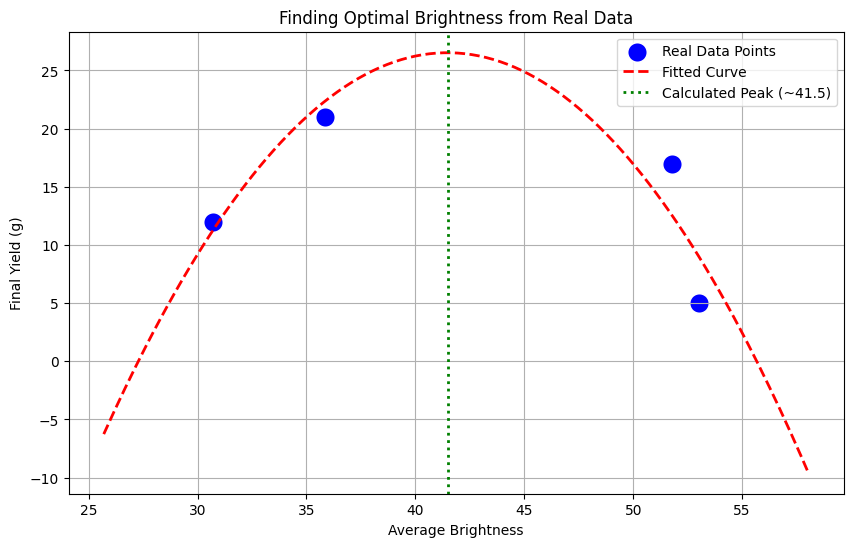

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


df_real_logs = pd.read_csv('ndvi_light_growth_f_b.csv')

df_agg_real = df_real_logs.groupby('camera').agg(
    avg_brightness=('brightness', 'mean')
).reset_index()

df_agg_real['yield_g'] = [21.0, 17.0, 12.0, 5.0]

print("Real Aggregated Data") 
print(df_agg_real.round(2))

# fit model
X_real = df_agg_real[['avg_brightness']]
y_real = df_agg_real['yield_g']

#  train
degree = 2
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_real, y_real)

# Get the trained linear regression part of the pipeline
lm = model.named_steps['linearregression']
b = lm.coef_[1]
a = lm.coef_[2]

# get peak
peak_brightness = -b / (2 * a)

print(f"\nData-Driven Peak Brightness: {peak_brightness:.2f}")


# plot
X_smooth = np.linspace(X_real['avg_brightness'].min()-5, X_real['avg_brightness'].max()+5, 200).reshape(-1, 1)
y_pred_smooth = model.predict(X_smooth)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_agg_real, x='avg_brightness', y='yield_g', s=200, color='blue', label='Real Data Points')
plt.plot(X_smooth, y_pred_smooth, color='red', linestyle='--', lw=2, label='Fitted Curve')
plt.axvline(peak_brightness, color='green', linestyle=':', lw=2, label=f'Calculated Peak (~{peak_brightness:.1f})')

plt.title('Finding Optimal Brightness from Real Data')
plt.xlabel('Average Brightness')
plt.ylabel('Final Yield (g)')
plt.legend()
plt.grid(True)
plt.show()

## Polynomial regression, yield predictions

### mathematical asnswer

In [19]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# Set a random seed so our "artificial" data is reproducible
np.random.seed(42)

# --- Step 1: Load and Aggregate Your REAL Data ---
try:
    # Corrected filename to match uploaded file
    df_real_logs = pd.read_csv('ndvi_light_growth_f_b.csv')
    
    df_agg_real = df_real_logs.groupby('camera').agg(
        avg_brightness=('brightness', 'mean'),
        std_brightness=('brightness', 'std'),
        avg_ndvi=('mean', 'mean'),
        std_ndvi=('mean', 'std')
    ).reset_index()

    df_agg_real['yield_g'] = [21.0, 17.0, 12.0, 5.0]
    df_agg_real['source'] = 'Real Data'

except FileNotFoundError:
    print("Error: 'ndvi_light_growth_f_b.csv' not found. Please ensure it is uploaded.")
    exit()

# --- Step 2: Analyze Real Data to Inform Artificial Data Generation ---
df_brightness_analysis = df_agg_real[df_agg_real['camera'] != 'ba_1']
min_brightness = df_brightness_analysis['avg_brightness'].min()
max_brightness = df_brightness_analysis['avg_brightness'].max()

avg_ndvi_mean = df_agg_real['avg_ndvi'].mean()
avg_ndvi_std = df_agg_real['avg_ndvi'].std()
std_ndvi_mean = df_agg_real['std_ndvi'].mean()
std_ndvi_std = df_agg_real['std_ndvi'].std()
std_brightness_mean = df_agg_real['std_brightness'].mean()
std_brightness_std = df_agg_real['std_brightness'].std()


# --- Step 3: Generate More Realistic Artificial Data ---
num_artificial_plants = 10
art_avg_brightness = np.random.uniform(min_brightness, max_brightness, num_artificial_plants)

peak_brightness = 41
yield_decline_factor = 0.04
art_yield_g = (21 - (art_avg_brightness - peak_brightness)**2 * yield_decline_factor
               + np.random.randn(num_artificial_plants) * 1.5)

art_data = {
    'camera': [f'art_plant_{i}' for i in range(num_artificial_plants)],
    'avg_brightness': art_avg_brightness,
    'std_brightness': np.random.normal(std_brightness_mean, std_brightness_std, num_artificial_plants),
    'avg_ndvi': np.random.normal(avg_ndvi_mean, avg_ndvi_std, num_artificial_plants),
    'std_ndvi': np.random.normal(std_ndvi_mean, std_ndvi_std, num_artificial_plants),
    'yield_g': art_yield_g,
    'source': 'Artificial Data'
}
df_agg_art = pd.DataFrame(art_data)
df_agg_art['std_brightness'] = df_agg_art['std_brightness'].clip(lower=0)


# --- Step 4: Combine Data and Add Anchor Point ---
df_combined = pd.concat([df_agg_real, df_agg_art], ignore_index=True)
zero_point = pd.DataFrame([{
    'camera': 'anchor', 'avg_brightness': 0, 'std_brightness': 0,
    'avg_ndvi': 0, 'std_ndvi': 0, 'yield_g': 0, 'source': 'Anchor Point'
}])
df_combined = pd.concat([df_combined, zero_point], ignore_index=True)


# --- Step 5: Train Model and Extract the Equation ---
X = df_combined[['avg_brightness']]
y = df_combined['yield_g']

degree = 2
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_model.fit(X, y)

# Extract the coefficients from the trained model
lm = poly_model.named_steps['linearregression']
c = lm.intercept_
b = lm.coef_[1]
a = lm.coef_[2]

print("\n" + "="*50)
print("          PREDICTIVE GROWTH EQUATION")
print("="*50)
print(f"Yield (g) = ({a:.4f}) * Brightness² + ({b:.4f}) * Brightness + ({c:.4f})")
print("="*50)


# --- Step 6: Analyze Deviation on Real Data ---
# Use the trained model to predict yield for the REAL plants
X_real = df_agg_real[['avg_brightness']]
df_agg_real['predicted_yield'] = poly_model.predict(X_real)

# Calculate the difference between real and predicted yield
df_agg_real['deviation (error)'] = df_agg_real['yield_g'] - df_agg_real['predicted_yield']

# Calculate the overall error for the model on real data (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(df_agg_real['yield_g'], df_agg_real['predicted_yield']))

print("\n" + "="*50)
print("         MODEL PERFORMANCE ON REAL DATA")
print("="*50)
print(df_agg_real[['camera', 'avg_brightness', 'yield_g', 'predicted_yield', 'deviation (error)']].round(2))
print("\n" + "-"*50)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f} g")
print("-"*50)
print("Note: RMSE is a measure of the average prediction error. Lower is better.")


          PREDICTIVE GROWTH EQUATION
Yield (g) = (-0.0138) * Brightness² + (1.0305) * Brightness + (-0.8987)

         MODEL PERFORMANCE ON REAL DATA
  camera  avg_brightness  yield_g  predicted_yield  deviation (error)
0   ba_1           35.83     21.0            18.25               2.75
1   ba_2           51.79     17.0            15.33               1.67
2   ba_3           30.69     12.0            17.69              -5.69
3   ba_4           53.04      5.0            14.81              -9.81

--------------------------------------------------
Root Mean Squared Error (RMSE): 5.8916 g
--------------------------------------------------
Note: RMSE is a measure of the average prediction error. Lower is better.


--- Real Aggregated Data ---
  camera  avg_brightness  std_brightness  avg_ndvi  std_ndvi  yield_g  \
0   ba_1           35.83           32.30      0.50      0.25     21.0   
1   ba_2           51.79           25.82      0.74      0.25     17.0   
2   ba_3           30.69           30.31      0.57      0.31     12.0   
3   ba_4           53.04           26.92      0.69      0.28      5.0   

      source  
0  Real Data  
1  Real Data  
2  Real Data  
3  Real Data  

--- Generating Realistic Artificial Data ---

Added (0,0) anchor point to the dataset.


/opt/conda/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


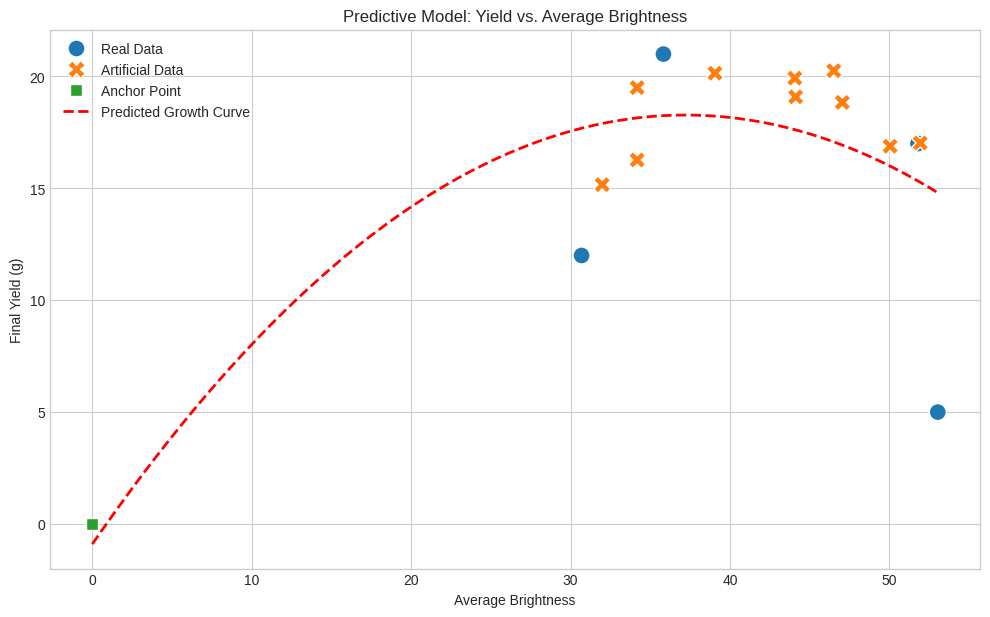


Successfully created and saved 'predictive_growth_curve_with_anchor.png'


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Set a random seed so our "artificial" data is reproducible
np.random.seed(42)

# --- Step 1: Load and Aggregate Your REAL Data ---
try:
    df_real_logs = pd.read_csv('ndvi_light_growth_f_b.csv') # unfiltered
    
    df_agg_real = df_real_logs.groupby('camera').agg(
        avg_brightness=('brightness', 'mean'),
        std_brightness=('brightness', 'std'),
        avg_ndvi=('mean', 'mean'),
        std_ndvi=('mean', 'std')
    ).reset_index()

    df_agg_real['yield_g'] = [21.0, 17.0, 12.0, 5.0]
    df_agg_real['source'] = 'Real Data'
    
    print("--- Real Aggregated Data ---")
    print(df_agg_real.round(2))

except FileNotFoundError:
    print("Error: 'ndvi_light_growth_f_b.csv' not found. Please ensure it is uploaded.")
    exit()

min_brightness = df_brightness_analysis['avg_brightness'].min()
max_brightness = df_brightness_analysis['avg_brightness'].max()

avg_ndvi_mean = df_agg_real['avg_ndvi'].mean()
avg_ndvi_std = df_agg_real['avg_ndvi'].std()
std_ndvi_mean = df_agg_real['std_ndvi'].mean()
std_ndvi_std = df_agg_real['std_ndvi'].std()
std_brightness_mean = df_agg_real['std_brightness'].mean()
std_brightness_std = df_agg_real['std_brightness'].std()


# --- Step 3: Generate More Realistic Artificial Data ---
print("\n--- Generating Realistic Artificial Data ---")
num_artificial_plants = 10
art_avg_brightness = np.random.uniform(min_brightness, max_brightness, num_artificial_plants)

peak_brightness = 41
yield_decline_factor = 0.04
art_yield_g = (21 - (art_avg_brightness - peak_brightness)**2 * yield_decline_factor
               + np.random.randn(num_artificial_plants) * 1.5)

art_data = {
    'camera': [f'art_plant_{i}' for i in range(num_artificial_plants)],
    'avg_brightness': art_avg_brightness,
    'std_brightness': np.random.normal(std_brightness_mean, std_brightness_std, num_artificial_plants),
    'avg_ndvi': np.random.normal(avg_ndvi_mean, avg_ndvi_std, num_artificial_plants),
    'std_ndvi': np.random.normal(std_ndvi_mean, std_ndvi_std, num_artificial_plants),
    'yield_g': art_yield_g,
    'source': 'Artificial Data'
}
df_agg_art = pd.DataFrame(art_data)
df_agg_art['std_brightness'] = df_agg_art['std_brightness'].clip(lower=0)


# --- Step 4: Combine Data and Add Anchor Point ---
# Combine real and artificial data first
df_combined = pd.concat([df_agg_real, df_agg_art], ignore_index=True)

# --- KEY UPDATE: Add the (0, 0) anchor point ---
# This teaches the model that zero brightness results in zero yield.
zero_point = pd.DataFrame([{
    'camera': 'anchor', 'avg_brightness': 0, 'std_brightness': 0,
    'avg_ndvi': 0, 'std_ndvi': 0, 'yield_g': 0, 'source': 'Anchor Point'
}])
df_combined = pd.concat([df_combined, zero_point], ignore_index=True)
print("\nAdded (0,0) anchor point to the dataset.")


# --- Step 5: Train Model and Plot ---
X = df_combined[['avg_brightness']]
y = df_combined['yield_g']

degree = 2
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_model.fit(X, y)

X_smooth = np.linspace(X['avg_brightness'].min(), X['avg_brightness'].max(), 200).reshape(-1, 1)
y_pred_smooth = poly_model.predict(X_smooth)

plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_combined, x='avg_brightness', y='yield_g', hue='source', s=150, style='source',
                hue_order=['Real Data', 'Artificial Data', 'Anchor Point'])
plt.plot(X_smooth, y_pred_smooth, color='red', linestyle='--', lw=2, label='Predicted Growth Curve')

plt.title('Predictive Model: Yield vs. Average Brightness')
plt.xlabel('Average Brightness')
plt.ylabel('Final Yield (g)')
plt.legend()
plt.grid(True)
plt.savefig('predictive_growth_curve_with_anchor.png')
plt.show()

print("\nSuccessfully created and saved 'predictive_growth_curve_with_anchor.png'")

## does ndvi/brightness stunt growth?

In [9]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample

 #   Uses bootstrapping to calculate a 95% confidence interval for the
 #   polynomial regression coefficients, limited to the first N days of data.

def analyze_stunted_growth_bootstrap(input_csv="ndvi_light_growth_f_b.csv", n_bootstraps=1000, days_to_analyze=5):

    try:
        df = pd.read_csv(input_csv)
    except FileNotFoundError:
        print(f"Error: The file {input_csv} was not found.")
        return

    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values(by=['camera', 'datetime'])

    print(f"Original total records: {len(df)}")
    
    # Find the start date for each camera individually
    df['start_date'] = df.groupby('camera')['datetime'].transform('min')
    df = df[df['datetime'] < df['start_date'] + pd.Timedelta(days=days_to_analyze)]
    print(f"Records after limiting to first {days_to_analyze} days for each camera: {len(df)}")

    # Calculate RGR 
    df = df[df['growth_metric'] > 0].copy()
    df['log_biomass'] = np.log(df['growth_metric'])
    df['log_biomass_diff'] = df.groupby('camera')['log_biomass'].diff()
    df['time_diff_days'] = df.groupby('camera')['datetime'].diff() / np.timedelta64(1, 'D')
    df['rgr'] = df['log_biomass_diff'] / df['time_diff_days']
    df['prev_brightness'] = df.groupby('camera')['brightness'].shift(1)
    df['prev_ndvi'] = df.groupby('camera')['mean'].shift(1)
    df_analysis = df.dropna(subset=['rgr', 'prev_brightness', 'prev_ndvi'])
    
    # Sunlight vs Growth
    beta2_coeffs_bright = []
    for _ in range(n_bootstraps):
        sample = resample(df_analysis)
        X_bright = sample[['prev_brightness']]
        y_rgr = sample['rgr']
        poly_model = make_pipeline(PolynomialFeatures(2), LinearRegression())
        poly_model.fit(X_bright, y_rgr)
        beta2_coeffs_bright.append(poly_model.named_steps['linearregression'].coef_[2])
    
    confidence_interval_bright = np.percentile(beta2_coeffs_bright, [2.5, 97.5])
    
    print("\n Brightness vs. Growth Rate (5 Days)")
    print(f"95% Confidence Interval for (Brightness^2) coefficient: {confidence_interval_bright}")
    if confidence_interval_bright[0] < 0 and confidence_interval_bright[1] < 0:
        print("Evidence STRONGLY SUPPORTS the hypothesis.")
    else:
        print("Evidence does NOT support the hypothesis.")

    # NDVI vs. Growth 
    beta2_coeffs_ndvi = []
    for _ in range(n_bootstraps):
        sample = resample(df_analysis)
        X_ndvi = sample[['prev_ndvi']]
        y_rgr = sample['rgr']
        poly_model = make_pipeline(PolynomialFeatures(2), LinearRegression())
        poly_model.fit(X_ndvi, y_rgr)
        beta2_coeffs_ndvi.append(poly_model.named_steps['linearregression'].coef_[2])

    confidence_interval_ndvi = np.percentile(beta2_coeffs_ndvi, [2.5, 97.5])

    print("\n NDVI vs  Growth Rate (5 Days)")
    print(f"95% Confidence Interval for (NDVI^2) coefficient: {confidence_interval_ndvi}")
    if confidence_interval_ndvi[0] < 0 and confidence_interval_ndvi[1] < 0:
        print("Evidence STRONGLY SUPPORTS the hypothesis.")
    else:
        print("Evidence does NOT support the hypothesis.")

if __name__ == "__main__":
    analyze_stunted_growth_bootstrap()

Original total records: 5076
Records after limiting to first 5 days for each camera: 2723

 Brightness vs. Growth Rate (5 Days)
95% Confidence Interval for (Brightness^2) coefficient: [-0.01111669  0.01937145]
Evidence does NOT support the hypothesis.

 NDVI vs  Growth Rate (5 Days)
95% Confidence Interval for (NDVI^2) coefficient: [259.51306965 530.29794874]
Evidence does NOT support the hypothesis.


##

# Light 

## avg ndvi per day

Plot has been saved as 'average_ndvi_per_day.png'


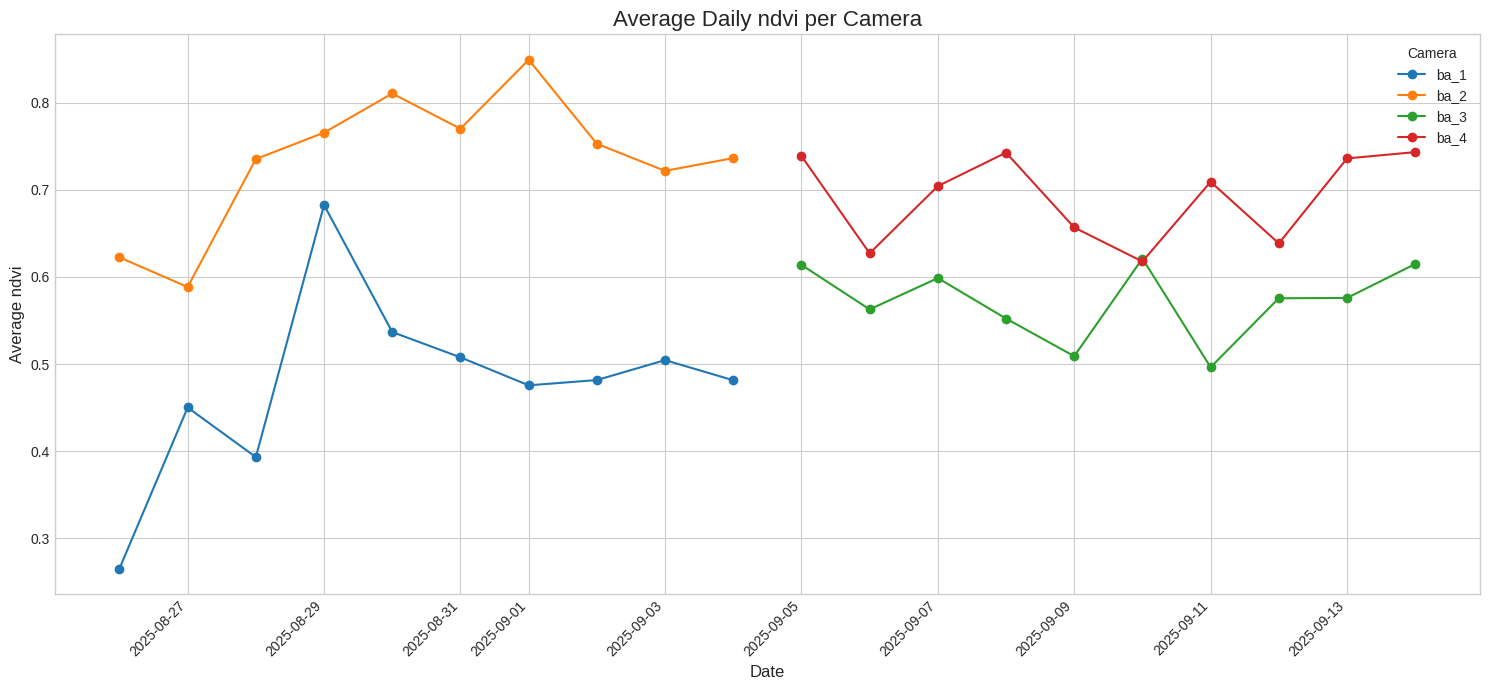

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the dataset from the CSV file
try:
    df = pd.read_csv('ndvi_light_growth_f_b.csv')

    # Convert the 'datetime' column to a proper datetime object to extract the date
    df['date'] = pd.to_datetime(df['datetime']).dt.date

    # Group data by the new 'date' column and 'camera'
    # Then, calculate the mean of the 'brightness' column for each group
    average_brightness_per_day = df.groupby(['date', 'camera'])['mean'].mean().reset_index()

    # Pivot the data to have dates as the index and each camera as a column
    pivot_df = average_brightness_per_day.pivot(index='date', columns='camera', values='mean')

    # Create the plot
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(15, 7))

    # Plot each camera's data using markers and lines for clarity
    pivot_df.plot(ax=ax, marker='o', linestyle='-')

    # --- Formatting the plot for better readability ---
    ax.set_title('Average Daily ndvi per Camera', fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Average ndvi', fontsize=12)
    ax.legend(title='Camera')

    # Improve date formatting on the x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45, ha='right') # Rotate labels to prevent overlap

    plt.tight_layout() # Adjust layout to make sure everything fits

    # Save the figure to a file
    plt.savefig('average_ndvi_per_day.png')

    print("Plot has been saved as 'average_ndvi_per_day.png'")

except FileNotFoundError:
    print("Error: 'filtered_ndvi_zscore.csv' not found. Please ensure the file is in the correct directory.")

## avg brightness per day

Plot has been saved as 'average_brightness_per_day.png'


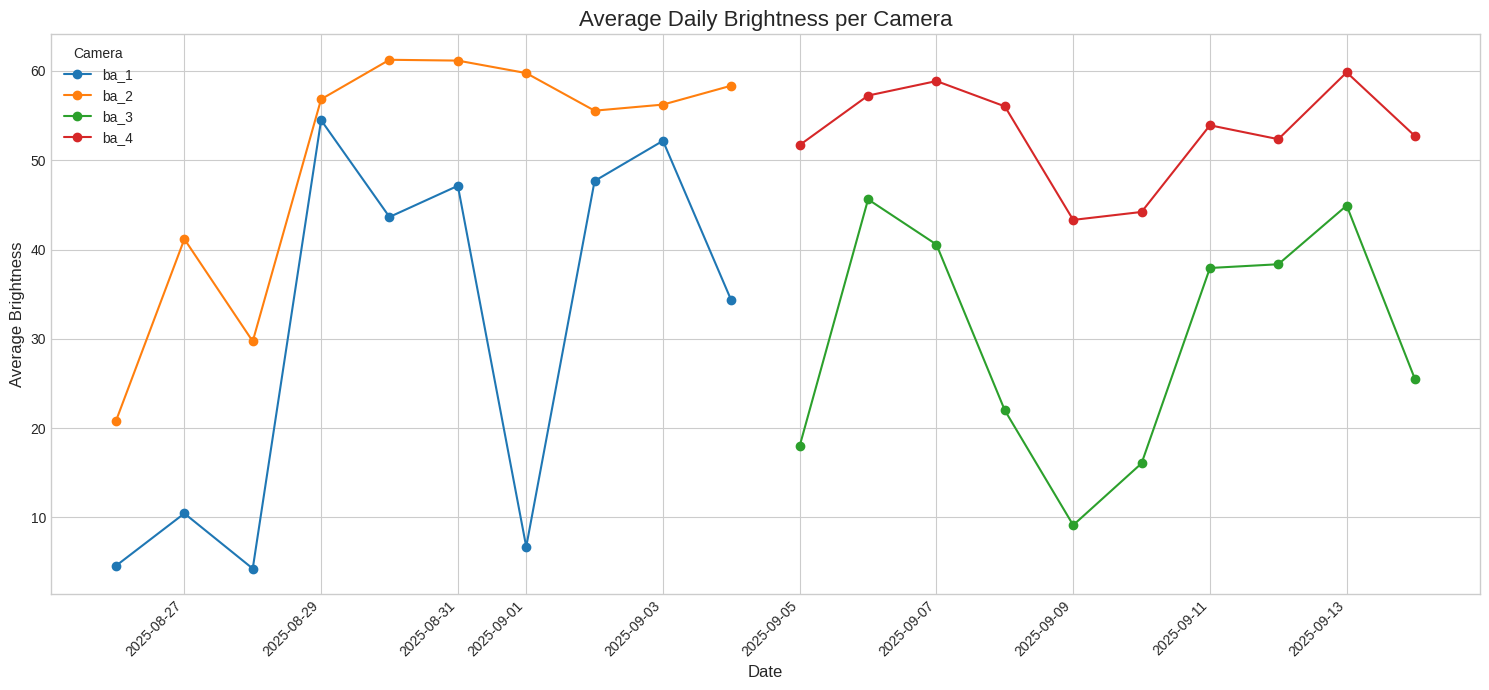

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the dataset from the CSV file
try:
    df = pd.read_csv('ndvi_light_growth_f_b.csv')

    # Convert the 'datetime' column to a proper datetime object to extract the date
    df['date'] = pd.to_datetime(df['datetime']).dt.date

    # Group data by the new 'date' column and 'camera'
    # Then, calculate the mean of the 'brightness' column for each group
    average_brightness_per_day = df.groupby(['date', 'camera'])['brightness'].mean().reset_index()

    # Pivot the data to have dates as the index and each camera as a column
    pivot_df = average_brightness_per_day.pivot(index='date', columns='camera', values='brightness')

    # Create the plot
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(15, 7))

    # Plot each camera's data using markers and lines for clarity
    pivot_df.plot(ax=ax, marker='o', linestyle='-')

    # --- Formatting the plot for better readability ---
    ax.set_title('Average Daily Brightness per Camera', fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Average Brightness', fontsize=12)
    ax.legend(title='Camera')

    # Improve date formatting on the x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45, ha='right') # Rotate labels to prevent overlap

    plt.tight_layout() # Adjust layout to make sure everything fits

    # Save the figure to a file
    plt.savefig('average_brightness_per_day.png')

    print("Plot has been saved as 'average_brightness_per_day.png'")

except FileNotFoundError:
    print("Error: 'filtered_ndvi_zscore.csv' not found. Please ensure the file is in the correct directory.")

## daily plots

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

# --- Configuration ---
INPUT_CSV = "ndvi_light_growth_f_b.csv"
OUTPUT_DIR = "daily_plots" # A dedicated folder for the output images

try:
    # --- Create Output Directory ---
    # Create the directory to store plots if it doesn't already exist
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
        print(f"Created output directory: '{OUTPUT_DIR}'")

    # --- Data Loading and Preparation ---
    df = pd.read_csv(INPUT_CSV)

    # Convert 'datetime' column to datetime objects
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # NEW: Create a 'date' column to easily group by day
    df['date'] = df['datetime'].dt.date
    
    # Get the unique camera names from the 'camera' column
    unique_cameras = df['camera'].unique()
    
    if len(unique_cameras) == 0:
        print("No cameras found in the 'camera' column.")
    else:
        print(f"Found cameras: {', '.join(unique_cameras)}")

    # --- Plotting Loop ---
    # Loop through each unique camera
    for camera_name in unique_cameras:
        print(f"Processing camera: {camera_name}...")
        
        # Filter the DataFrame for the current camera
        df_camera = df[df['camera'] == camera_name]

        # NEW: Get the unique dates for this specific camera
        unique_dates_for_camera = df_camera['date'].unique()

        # NEW: Loop through each day for the current camera
        for day in unique_dates_for_camera:
            day_str = day.strftime('%Y-%m-%d')
            print(f"  Generating plot for day: {day_str}...")

            # Filter the camera's data for the current day
            df_day = df_camera[df_camera['date'] == day].sort_values('datetime')

            # Skip if there's not enough data to plot a line
            if df_day.empty or len(df_day) < 2:
                print(f"    Not enough data to plot for {camera_name} on {day_str}. Skipping.")
                continue

            # --- Plotting ---
            fig, ax1 = plt.subplots(figsize=(15, 7))

            # Plot Brightness on the first Y-axis (left)
            color = 'tab:blue'
            ax1.set_xlabel('Time of Day')
            ax1.set_ylabel('Brightness', color=color)
            ax1.plot(df_day['datetime'], df_day['brightness'], color=color, label='Brightness', marker='o', linestyle='-')
            ax1.tick_params(axis='y', labelcolor=color)
            ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

            # Create a second Y-axis (right)
            ax2 = ax1.twinx()
            color = 'tab:green'
            ax2.set_ylabel('Mean NDVI', color=color)
            ax2.plot(df_day['datetime'], df_day['mean'], color=color, label='Mean NDVI', marker='o', linestyle='-')
            ax2.tick_params(axis='y', labelcolor=color)

            # --- Formatting ---
            # UPDATED: Format x-axis to show Hour:Minute, as each plot is now just one day
            ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
            ax1.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=10))
            fig.autofmt_xdate() # Improve rotation and alignment of time labels

            # UPDATED: Set a dynamic title including the camera and the specific day
            plt.title(f'Brightness and Mean NDVI for {camera_name} on {day_str}')
            fig.tight_layout()

            # Create a single legend for both lines
            lines, labels = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax2.legend(lines + lines2, labels + labels2, loc='upper left')

            # --- Save the plot to a unique file ---
            # UPDATED: Create a unique filename for each camera and day
            output_filename = f"{camera_name}_{day_str}.png"
            output_path = os.path.join(OUTPUT_DIR, output_filename)
            plt.savefig(output_path)
            plt.close(fig) # Close the figure to free up memory
            
            print(f"    Saved plot as '{output_path}'")

except FileNotFoundError:
    print(f"Error: '{INPUT_CSV}' not found. Please ensure the file is in the correct directory.")
except Exception as e:
    print(f"An error occurred: {e}")

Found cameras: ba_2, ba_1, ba_4, ba_3
Processing camera: ba_2...
  Generating plot for day: 2025-08-26...
    Saved plot as 'daily_plots/ba_2_2025-08-26.png'
  Generating plot for day: 2025-08-27...
    Saved plot as 'daily_plots/ba_2_2025-08-27.png'
  Generating plot for day: 2025-08-28...
    Saved plot as 'daily_plots/ba_2_2025-08-28.png'
  Generating plot for day: 2025-08-29...
    Saved plot as 'daily_plots/ba_2_2025-08-29.png'
  Generating plot for day: 2025-08-30...
    Saved plot as 'daily_plots/ba_2_2025-08-30.png'
  Generating plot for day: 2025-08-31...
    Saved plot as 'daily_plots/ba_2_2025-08-31.png'
  Generating plot for day: 2025-09-01...
    Saved plot as 'daily_plots/ba_2_2025-09-01.png'
  Generating plot for day: 2025-09-02...
    Saved plot as 'daily_plots/ba_2_2025-09-02.png'
  Generating plot for day: 2025-09-03...
    Saved plot as 'daily_plots/ba_2_2025-09-03.png'
  Generating plot for day: 2025-09-04...
    Saved plot as 'daily_plots/ba_2_2025-09-04.png'
Proce

## ndvi - brightness

### plots

--- Statistical Relationship ---
Overall Correlation between Brightness and NDVI: 0.5780

Saved plot: 'overall_ndvi_vs_brightness.png'
Saved plot: 'per_camera_ndvi_vs_brightness.png'


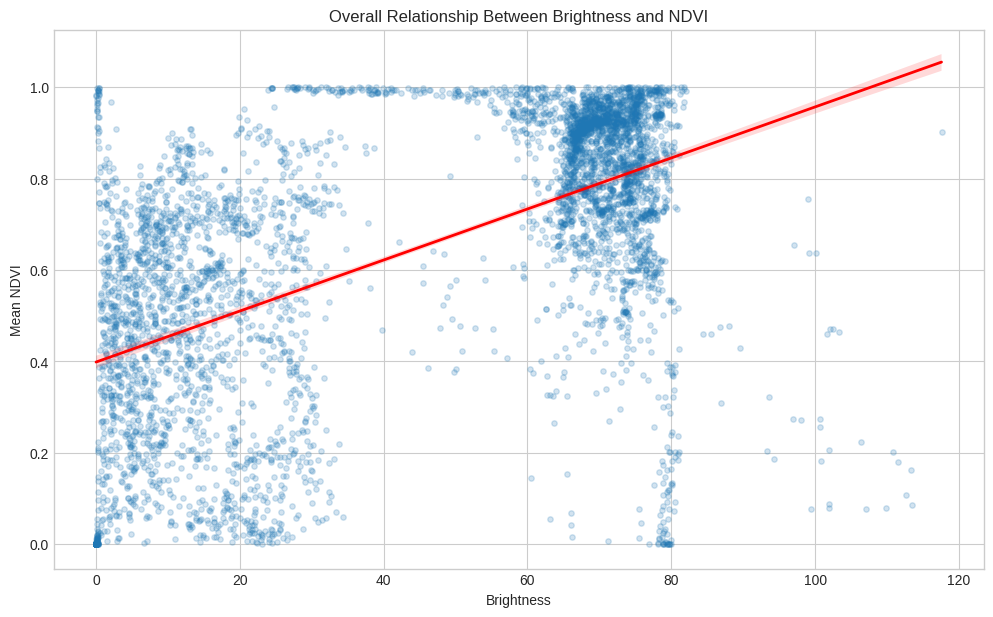

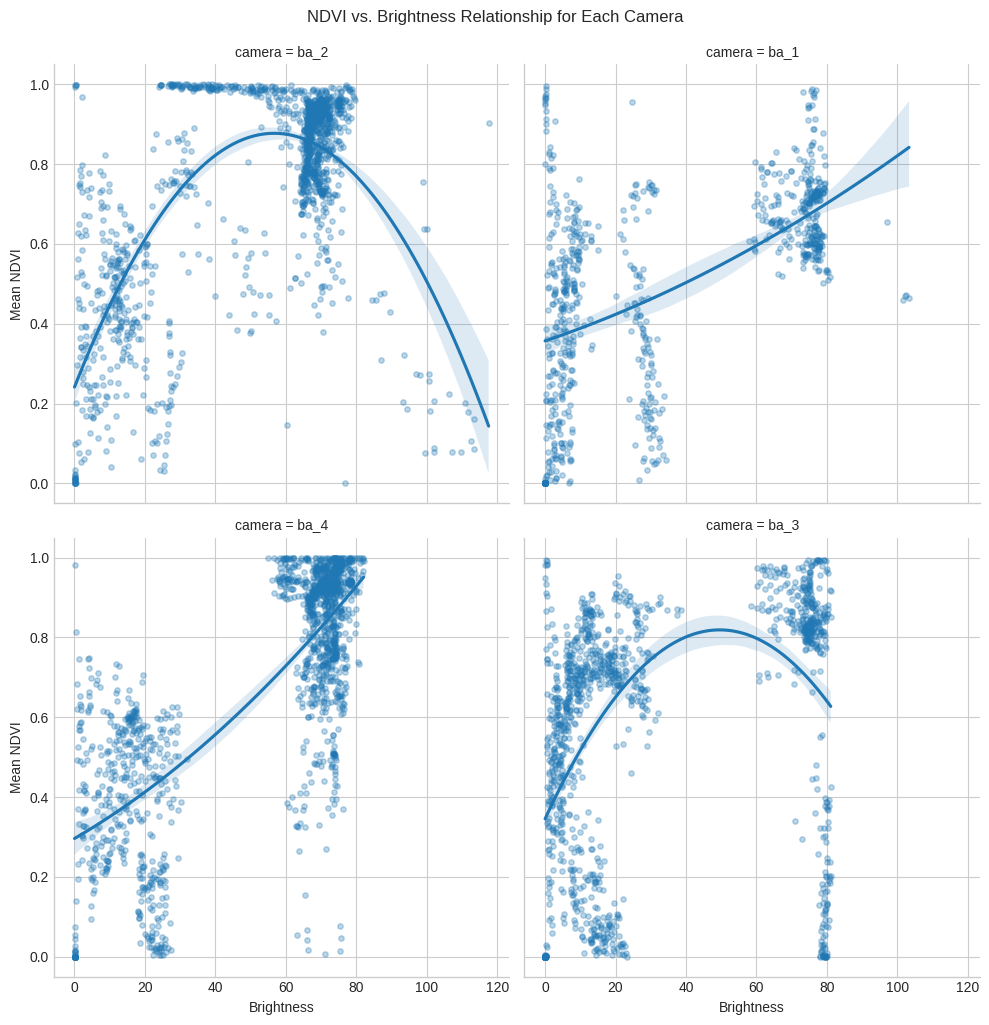

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load the Dataset ---
try:
    df = pd.read_csv('ndvi_light_growth_f_b.csv')
    df['datetime'] = pd.to_datetime(df['datetime'])
except FileNotFoundError:
    print("Error: 'ndvi_light_growth_f_b.csv' not found. Please ensure the file is uploaded.")
    df = pd.DataFrame()

if not df.empty:
    # --- 2. Statistical Analysis: Correlation ---
    # Calculate the Pearson correlation coefficient between brightness and mean NDVI.
    # A value near +1 indicates a strong positive linear relationship,
    # -1 a strong negative, and 0 means no linear relationship.
    correlation = df['brightness'].corr(df['mean'])
    print(f"--- Statistical Relationship ---")
    print(f"Overall Correlation between Brightness and NDVI: {correlation:.4f}\n")

    # --- 3. Visual Analysis: Overall Trend ---
    # Create a scatter plot with a regression line for the entire dataset.
    plt.figure(figsize=(12, 7))
    sns.regplot(data=df, x='brightness', y='mean',
                scatter_kws={'alpha': 0.2, 's': 15},
                line_kws={'color': 'red', 'lw': 2})
    plt.title('Overall Relationship Between Brightness and NDVI')
    plt.xlabel('Brightness')
    plt.ylabel('Mean NDVI')
    plt.grid(True)
    plt.savefig('overall_ndvi_vs_brightness.png')
    print("Saved plot: 'overall_ndvi_vs_brightness.png'")


    # --- 4. Visual Analysis: Per-Camera Trend ---
    # Use seaborn's lmplot to create separate plots for each camera.
    # This is the best way to see if each plant responded differently.
    # We'll fit a 2nd-degree polynomial (order=2) to better see the curve.
    g = sns.lmplot(data=df, x='brightness', y='mean', col='camera',
                   col_wrap=2, height=5,
                   scatter_kws={'alpha': 0.3, 's': 15},
                   order=2) # order=2 fits a curve instead of a straight line

    g.fig.suptitle('NDVI vs. Brightness Relationship for Each Camera', y=1.02)
    g.set_axis_labels('Brightness', 'Mean NDVI')
    plt.savefig('per_camera_ndvi_vs_brightness.png')
    print("Saved plot: 'per_camera_ndvi_vs_brightness.png'")

else:
    print("DataFrame is empty, cannot perform analysis.")

### math

In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# --- 1. Load the Dataset ---
try:
    df = pd.read_csv('ndvi_light_growth_f_b.csv')
    df['datetime'] = pd.to_datetime(df['datetime'])
except FileNotFoundError:
    print("Error: 'ndvi_light_growth_f_b.csv' not found. Please ensure the file is uploaded.")
    df = pd.DataFrame()

if not df.empty:
    # --- 2. Overall Statistical Relationship: Correlation ---
    correlation = df['brightness'].corr(df['mean'])
    print("\n" + "="*50)
    print("        OVERALL STATISTICAL CORRELATION")
    print("="*50)
    print(f"The overall Pearson correlation between Brightness and NDVI is: {correlation:.4f}")
    print("Note: This measures the linear trend of all data points combined.")

    # --- 3. Per-Camera Mathematical Equations ---
    print("\n" + "="*50)
    print("        PER-CAMERA PREDICTIVE EQUATIONS")
    print("="*50)
    
    # Loop through each camera to calculate its unique equation
    for camera_id in sorted(df['camera'].unique()):
        camera_data = df[df['camera'] == camera_id]
        
        # Ensure there's enough data to fit a curve
        if len(camera_data) > 3:
            X = camera_data[['brightness']]
            y = camera_data['mean']
            
            # Create and train a 2nd-degree polynomial model
            degree = 2
            poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
            poly_model.fit(X, y)
            
            # Extract the coefficients of the equation: y = ax^2 + bx + c
            lm = poly_model.named_steps['linearregression']
            c = lm.intercept_
            b = lm.coef_[1]
            a = lm.coef_[2]
            
            print(f"\n--- {camera_id.upper()} ---")
            print(f"NDVI = ({a:.6f}) * Brightness² + ({b:.4f}) * Brightness + ({c:.4f})")
        else:
            print(f"\n--- {camera_id.upper()} ---")
            print("Not enough data to fit a reliable curve.")
else:
    print("DataFrame is empty, cannot perform analysis.")


        OVERALL STATISTICAL CORRELATION
The overall Pearson correlation between Brightness and NDVI is: 0.5780
Note: This measures the linear trend of all data points combined.

        PER-CAMERA PREDICTIVE EQUATIONS

--- BA_1 ---
NDVI = (0.000016) * Brightness² + (0.0030) * Brightness + (0.3568)

--- BA_2 ---
NDVI = (-0.000198) * Brightness² + (0.0224) * Brightness + (0.2412)

--- BA_3 ---
NDVI = (-0.000193) * Brightness² + (0.0191) * Brightness + (0.3451)

--- BA_4 ---
NDVI = (0.000035) * Brightness² + (0.0051) * Brightness + (0.2960)


# cam_2 & cam_3

## use different alghorithm to check for similarity
### compare with others (is there less of a difference [cam_2,cam_3] than [cam_2,cam_1])

--- Statistical Comparison (Brightness & NDVI) ---
       brightness                                                        \
            count       mean        std       min        25%        50%   
camera                                                                    
ba_2       1444.0  51.794501  25.816397  0.009054  28.056039  66.125792   
ba_3       1275.0  30.691915  30.314766  0.007908   6.727283  15.569951   

                                 mean                                     \
              75%         max   count      mean       std  min       25%   
camera                                                                     
ba_2    69.480620  117.574704  1444.0  0.740603  0.253143  0.0  0.586151   
ba_3    71.714561   81.091045  1275.0  0.573049  0.307118  0.0  0.322121   

                                      
             50%       75%       max  
camera                                
ba_2    0.835815  0.932786  0.999972  
ba_3    0.688398  0.817966  0.994659

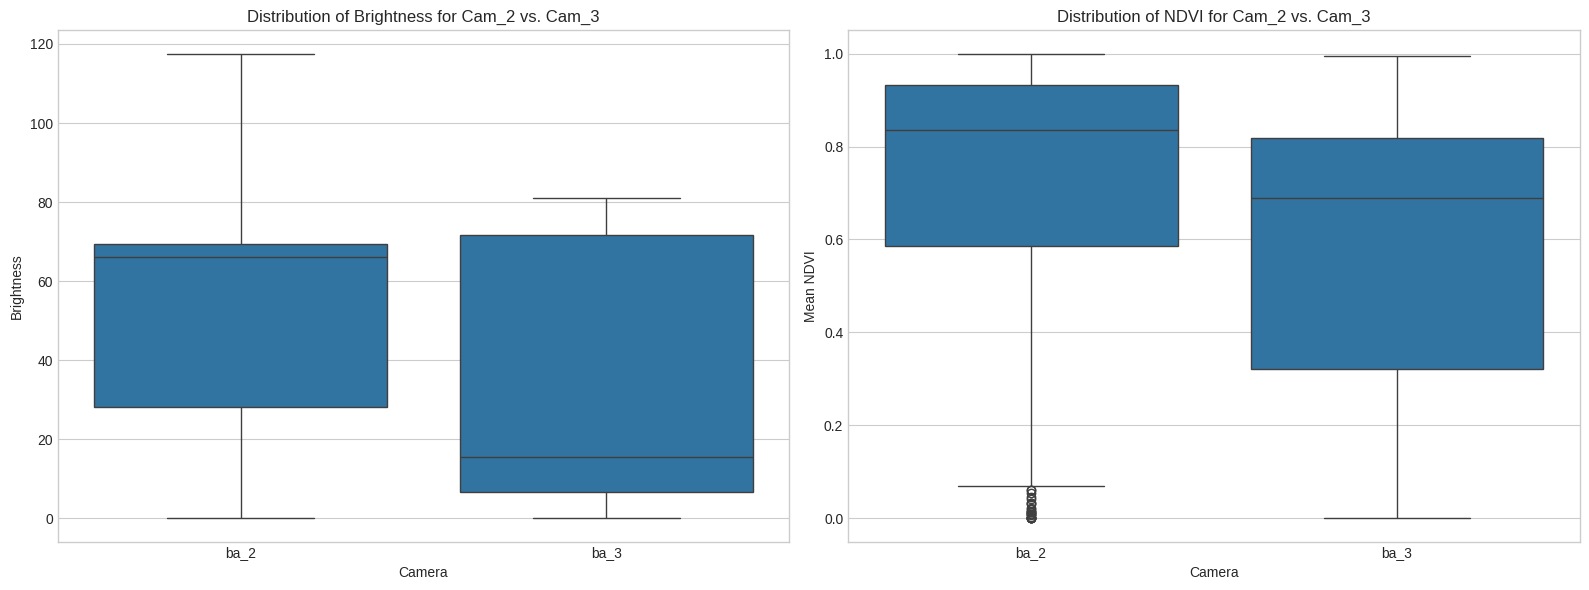

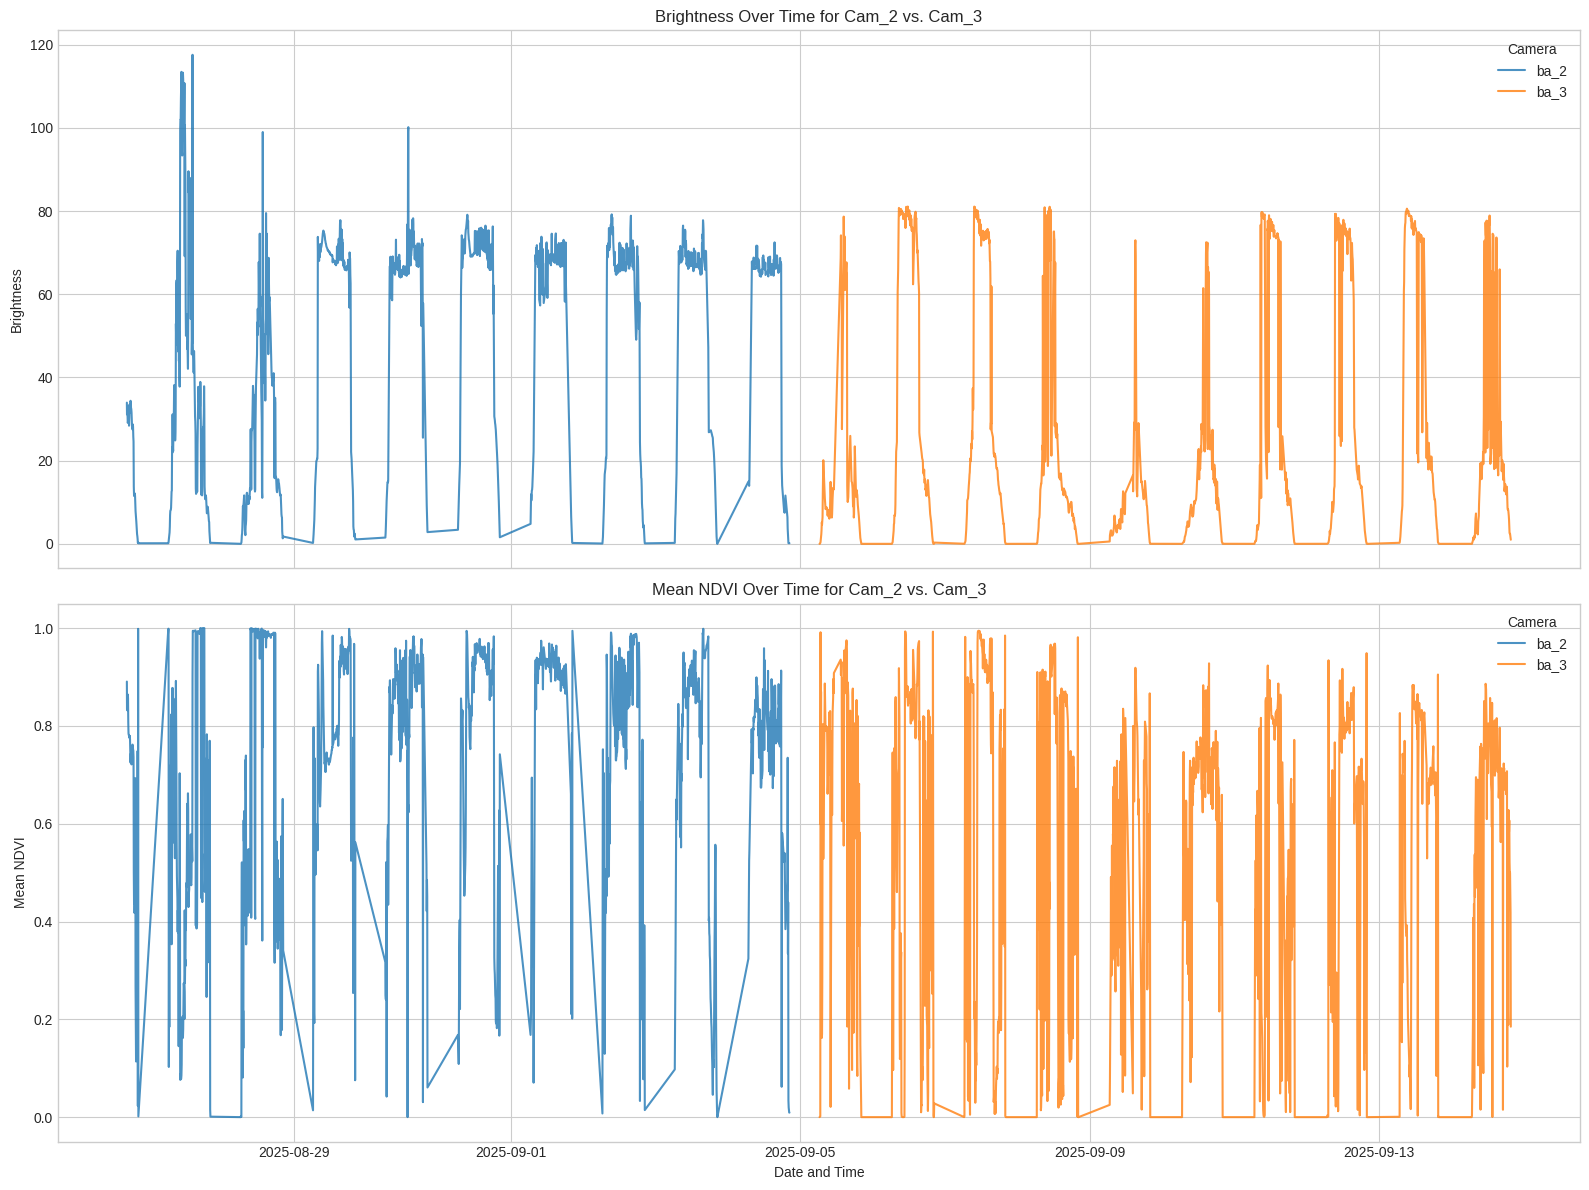

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
try:
    df = pd.read_csv('ndvi_light_growth_f_b.csv')
    df['datetime'] = pd.to_datetime(df['datetime'])
except FileNotFoundError:
    print("Error: 'ndvi_light_growth_f_b.csv' not found. Please ensure the file is in the same directory.")
    df = pd.DataFrame()

if not df.empty:
    # Filter for just cam_2 and cam_3
    df_c2_c3 = df[df['camera'].isin(['ba_2', 'ba_3'])].copy()

    # --- 1. Statistical Comparison ---
    # Calculate descriptive statistics for brightness and mean NDVI
    stats_comparison = df_c2_c3.groupby('camera')[['brightness', 'mean']].describe()
    print("--- Statistical Comparison (Brightness & NDVI) ---")
    print(stats_comparison)

    # --- 2. Visual Comparison: Box Plots ---
    # This shows the distribution of values for each camera side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Brightness comparison
    sns.boxplot(x='camera', y='brightness', data=df_c2_c3, ax=axes[0])
    axes[0].set_title('Distribution of Brightness for Cam_2 vs. Cam_3')
    axes[0].set_xlabel('Camera')
    axes[0].set_ylabel('Brightness')
    
    # NDVI comparison
    sns.boxplot(x='camera', y='mean', data=df_c2_c3, ax=axes[1])
    axes[1].set_title('Distribution of NDVI for Cam_2 vs. Cam_3')
    axes[1].set_xlabel('Camera')
    axes[1].set_ylabel('Mean NDVI')
    
    plt.tight_layout()
    plt.savefig('cam2_vs_cam3_boxplots.png')
    
    # --- 3. Visual Comparison: Time Series ---
    # This shows how brightness and NDVI changed over the course of the experiment
    fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
    
    # Brightness over time
    sns.lineplot(x='datetime', y='brightness', hue='camera', data=df_c2_c3, ax=axes[0], alpha=0.8)
    axes[0].set_title('Brightness Over Time for Cam_2 vs. Cam_3')
    axes[0].set_ylabel('Brightness')
    axes[0].legend(title='Camera')
    
    # NDVI over time
    sns.lineplot(x='datetime', y='mean', hue='camera', data=df_c2_c3, ax=axes[1], alpha=0.8)
    axes[1].set_title('Mean NDVI Over Time for Cam_2 vs. Cam_3')
    axes[1].set_xlabel('Date and Time')
    axes[1].set_ylabel('Mean NDVI')
    axes[1].legend(title='Camera')
    
    plt.tight_layout()
    plt.savefig('cam2_vs_cam3_timeseries.png')

    print("\nVisualizations 'cam2_vs_cam3_boxplots.png' and 'cam2_vs_cam3_timeseries.png' have been generated.")
else:
    print("DataFrame is empty, cannot perform analysis.")

In [16]:
import pandas as pd
import numpy as np
from scipy import stats

# --- 1. Load and Prepare Data ---
try:
    df = pd.read_csv('ndvi_light_growth_f_b.csv')
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # Filter for just cam_2 and cam_3
    cam2_data = df[df['camera'] == 'ba_2']
    cam3_data = df[df['camera'] == 'ba_3']

except FileNotFoundError:
    print("Error: 'ndvi_light_growth_f_b.csv' not found. Please ensure the file is uploaded.")
    df = pd.DataFrame()

if not df.empty:
    # --- 2. Method 1: Comparison of Descriptive Statistics ---
    # This gives a high-level overview of the data's characteristics.
    stats_c2 = cam2_data[['brightness', 'mean']].describe()
    stats_c3 = cam3_data[['brightness', 'mean']].describe()
    
    print("\n" + "="*50)
    print("        METHOD 1: DESCRIPTIVE STATISTICS")
    print("="*50)
    print("\n--- Camera 2 Statistics ---")
    print(stats_c2)
    print("\n--- Camera 3 Statistics ---")
    print(stats_c3)

    # --- 3. Method 2: Correlation of Time Series ---
    # This tests if the brightness and NDVI values for both cameras
    # rose and fell together over time. A high correlation means high similarity.
    
    # Combine the data on the same timestamps
    df_merged = pd.merge(cam2_data[['datetime', 'brightness', 'mean']],
                         cam3_data[['datetime', 'brightness', 'mean']],
                         on='datetime', suffixes=('_cam2', '_cam3'))

    # Calculate Pearson correlation
    brightness_corr = df_merged['brightness_cam2'].corr(df_merged['brightness_cam3'])
    ndvi_corr = df_merged['mean_cam2'].corr(df_merged['mean_cam3'])
    
    print("\n" + "="*50)
    print("        METHOD 2: CORRELATION OF PATTERNS")
    print("="*50)
    print(f"\nCorrelation of Brightness values over time: {brightness_corr:.4f}")
    print(f"Correlation of NDVI values over time:      {ndvi_corr:.4f}")

    # --- 4. Method 3: Kolmogorov-Smirnov (K-S) Test ---
    # This formal test checks if the two datasets are likely drawn from the
    # same underlying distribution. A high p-value suggests they are.
    
    ks_brightness_stat, ks_brightness_p = stats.ks_2samp(cam2_data['brightness'], cam3_data['brightness'])
    ks_ndvi_stat, ks_ndvi_p = stats.ks_2samp(cam2_data['mean'], cam3_data['mean'])
    
    print("\n" + "="*50)
    print("        METHOD 3: KOLMOGOROV-SMIRNOV (K-S) TEST")
    print("="*50)
    print("\n--- Brightness Distribution Comparison ---")
    print(f"K-S Statistic: {ks_brightness_stat:.4f}")
    print(f"P-value: {ks_brightness_p:.4f}")
    if ks_brightness_p > 0.05:
        print("Conclusion: The brightness distributions are NOT significantly different.")
    else:
        print("Conclusion: The brightness distributions ARE significantly different.")

    print("\n--- NDVI Distribution Comparison ---")
    print(f"K-S Statistic: {ks_ndvi_stat:.4f}")
    print(f"P-value: {ks_ndvi_p:.4f}")
    if ks_ndvi_p > 0.05:
        print("Conclusion: The NDVI distributions are NOT significantly different.")
    else:
        print("Conclusion: The NDVI distributions ARE significantly different.")


        METHOD 1: DESCRIPTIVE STATISTICS

--- Camera 2 Statistics ---
        brightness         mean
count  1444.000000  1444.000000
mean     51.794501     0.740603
std      25.816397     0.253143
min       0.009054     0.000000
25%      28.056039     0.586151
50%      66.125792     0.835815
75%      69.480620     0.932786
max     117.574704     0.999972

--- Camera 3 Statistics ---
        brightness         mean
count  1275.000000  1275.000000
mean     30.691915     0.573049
std      30.314766     0.307118
min       0.007908     0.000000
25%       6.727283     0.322121
50%      15.569951     0.688398
75%      71.714561     0.817966
max      81.091045     0.994659

        METHOD 2: CORRELATION OF PATTERNS

Correlation of Brightness values over time: nan
Correlation of NDVI values over time:      nan

        METHOD 3: KOLMOGOROV-SMIRNOV (K-S) TEST

--- Brightness Distribution Comparison ---
K-S Statistic: 0.4255
P-value: 0.0000
Conclusion: The brightness distributions ARE significa

# Growth

Successfully generated and saved the smoothed growth plots: 'smoothed_individual_growth.png'


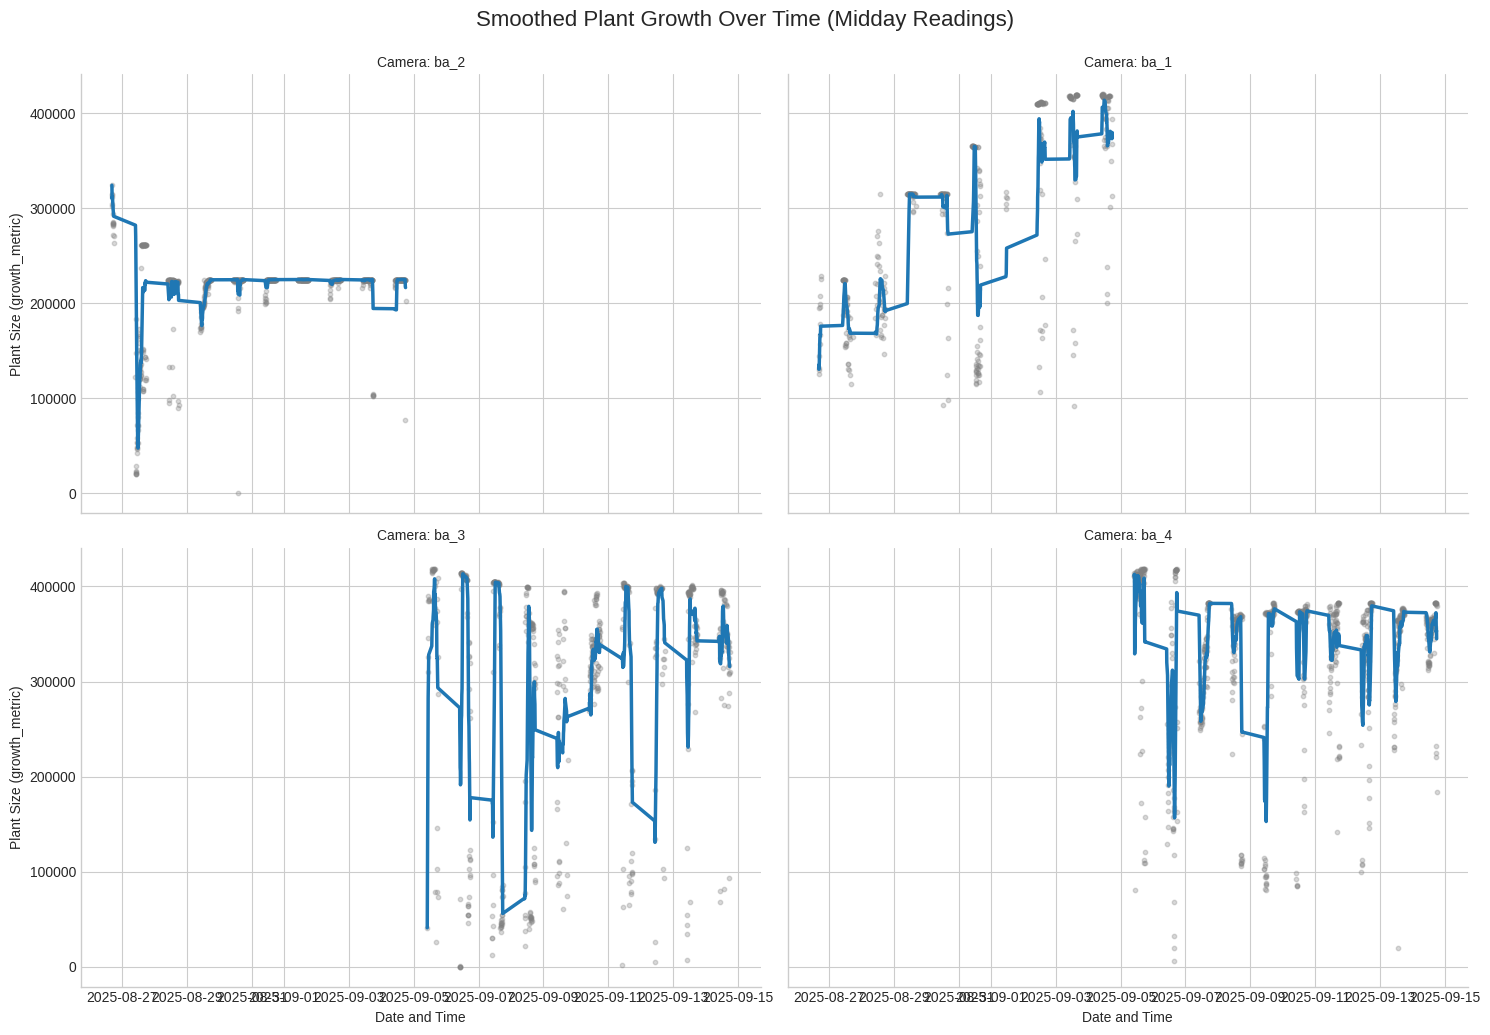

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load the Dataset ---
try:
    df = pd.read_csv('ndvi_light_growth_f_b.csv')
    df['datetime'] = pd.to_datetime(df['datetime'])
except FileNotFoundError:
    print("Error: 'ndvi_light_growth_f_b.csv' not found. Please ensure the file is in the same directory.")
    df = pd.DataFrame()

if not df.empty:
    # --- 2. Filter for Midday Readings (10:00 to 17:00) ---
    df_midday = df[(df['datetime'].dt.hour >= 10) & (df['datetime'].dt.hour <= 17)].copy()
    
    # --- 3. Calculate the Rolling Average for each camera ---
    # The 'window' is the number of data points to average. 20 is a good start.
    # We calculate it for each camera group separately to prevent data leakage.
    window_size = 20
    df_midday['smoothed_growth'] = df_midday.groupby('camera')['growth_metric'] \
                                            .transform(lambda x: x.rolling(window_size, min_periods=1).mean())

    # --- 4. Create Faceted Growth Plots ---
    g = sns.relplot(
        data=df_midday,
        x='datetime',
        y='smoothed_growth', # Plot the new smoothed data
        col='camera',
        col_wrap=2,
        kind='line',
        height=5,
        aspect=1.5,
        linewidth=2.5 # Make the smoothed line thicker
    )
    
    # --- 5. Overlay the Original Noisy Data for Comparison ---
    # Loop through each subplot axis to add the original data
    for i, ax in enumerate(g.axes.flat):
        camera_name = g.col_names[i]
        cam_data = df_midday[df_midday['camera'] == camera_name]
        ax.scatter(cam_data['datetime'], cam_data['growth_metric'], color='gray', s=10, alpha=0.3)
    
    # --- 6. Format the Plot for Clarity ---
    g.fig.suptitle('Smoothed Plant Growth Over Time (Midday Readings)', y=1.03, fontsize=16)
    g.set_axis_labels('Date and Time', 'Plant Size (growth_metric)')
    g.set_titles("Camera: {col_name}")
    
    # Save the resulting plot to a file
    plt.savefig('smoothed_individual_growth.png')
    
    print("Successfully generated and saved the smoothed growth plots: 'smoothed_individual_growth.png'")
else:
    print("DataFrame is empty, could not generate plot.")

In [25]:
import pandas as pd
from scipy import stats

# --- 1. Load and Prepare the Dataset ---
try:
    df = pd.read_csv('ndvi_light_growth_f_b.csv')
    df['datetime'] = pd.to_datetime(df['datetime'])
except FileNotFoundError:
    print("Error: 'ndvi_light_growth_f_b.csv' not found. Please ensure the file is in the same directory.")
    df = pd.DataFrame()

if not df.empty:
    # --- 2. Filter for Midday and Smooth the Data ---
    df_midday = df[(df['datetime'].dt.hour >= 10) & (df['datetime'].dt.hour <= 17)].copy()
    
    window_size = 20
    df_midday['smoothed_growth'] = df_midday.groupby('camera')['growth_metric'] \
                                            .transform(lambda x: x.rolling(window_size, min_periods=1).mean())

    # --- 3. Perform Trend Analysis for Each Camera ---
    print("\n" + "="*60)
    print("        MATHEMATICAL PROOF OF GROWTH (TREND ANALYSIS)")
    print("="*60)

    # Loop through each camera to analyze its growth trend
    for camera_id in sorted(df_midday['camera'].unique()):
        camera_data = df_midday[df_midday['camera'] == camera_id].dropna()
        
        # We need a numerical representation of time for the regression
        # We'll use "hours from the start of the experiment"
        start_time = camera_data['datetime'].min()
        camera_data['hours_from_start'] = (camera_data['datetime'] - start_time).dt.total_seconds() / 3600
        
        # Perform linear regression
        # This returns slope, intercept, r_value, p_value, and std_err
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            x=camera_data['hours_from_start'],
            y=camera_data['smoothed_growth']
        )
        
        print(f"\n--- Analysis for Camera: {camera_id.upper()} ---")
        print(f"Growth Rate (Slope): {slope:.2f} size units per hour")
        print(f"P-value: {p_value:.10f}")
        
        # Interpret the p-value
        alpha = 0.05
        if p_value < alpha and slope > 0:
            print("Conclusion: There is a STATISTICALLY SIGNIFICANT upward trend (growth).")
        else:
            print("Conclusion: The trend is not statistically significant.")
else:
    print("DataFrame is empty, cannot perform analysis.")


        MATHEMATICAL PROOF OF GROWTH (TREND ANALYSIS)

--- Analysis for Camera: BA_1 ---
Growth Rate (Slope): 970.40 size units per hour
P-value: 0.0000000000
Conclusion: There is a STATISTICALLY SIGNIFICANT upward trend (growth).

--- Analysis for Camera: BA_2 ---
Growth Rate (Slope): 139.77 size units per hour
P-value: 0.0000000000
Conclusion: There is a STATISTICALLY SIGNIFICANT upward trend (growth).

--- Analysis for Camera: BA_3 ---
Growth Rate (Slope): 208.66 size units per hour
P-value: 0.0000047771
Conclusion: There is a STATISTICALLY SIGNIFICANT upward trend (growth).

--- Analysis for Camera: BA_4 ---
Growth Rate (Slope): 82.07 size units per hour
P-value: 0.0005981830
Conclusion: There is a STATISTICALLY SIGNIFICANT upward trend (growth).
